# Step 1 - Introduction and Data Splitting

## Goals in this Notebook

- Introduce the reader to the project.
- Split the data into train and test. We will try to analyse the data as little as possible, just to make it possible to split it properly.

## Introduction

Before me I have two big datasets, containing information about accepted and rejected loans. I have been tasked with a few main goals:
- Create an accepted/rejected loan classification model, test and deploy.
- Create grade, subgrade, interest rate prediction models, test and deploy.

To achieve these main goals, I will need to complete a few steps, which I split into different notebooks:
1) Split the data into train and test.
2) Combine the two datasets, perform EDA, create an accepted/rejected loan classification model.
3) Perform EDA on the accepted loans dataset.
4) Perform feature selection for the three models.
5) Create the grade, subgrade, interest rate prediction models.
6) Test the models and deploy them.

In the project, I will be using these technologies and libraries:
- Python,
- Polars and Pandas (dataframes),
- Seaborn and Matplotlib (visualisation),
- Sklearn and XGBoost (modelling),
- Sklearn pipelines (data processing),
- Shap (feature importance)
- Boruta (feature selection),
- Docker (containerization),
- Google Cloud (deployment).

## Data Splitting

### Imports

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import functions

### Splitting accepted loans

Load in accepted loans data

In [2]:
data_folder = "data"
path = os.path.join(
    data_folder, "accepted_2007_to_2018q4.csv", "accepted_2007_to_2018Q4.csv"
)
df_acc = pl.scan_csv(path, dtypes={"id": str})

Check for duplicates

In [3]:
df_acc.select("id").collect().is_duplicated().value_counts()

,counts
bool,u32
false,2260701


There's none if looking at the id.

In [4]:
df_acc.drop("id").collect().is_duplicated().value_counts()

,counts
bool,u32
false,2260668
true,33


There are some if disregarding the id.

In [5]:
df_acc.unique(subset=df_acc.columns[1:]).drop(
    "id"
).collect().is_duplicated().value_counts()

,counts
bool,u32
false,2260669


In [6]:
functions.drop_duplicates_ignore_first_col(df_acc).drop(
    "id"
).collect().is_duplicated().value_counts()

,counts
bool,u32
false,2260669


Having dropped the duplicates, we see there were 33 identical entries. Good to get rid of them.

#### Cleaning the id column

The id column is typed as string right now. Let's see why.

In [7]:
df_non_digits = df_acc.filter(pl.col("id").str.contains("\D")).collect()
df_non_digits_drop_null_cols = df_non_digits[
    [s.name for s in df_non_digits if not (s.null_count() == df_non_digits.height)]
].to_numpy()
df_non_digits_drop_null_cols[0]

array(['Total amount funded in policy code 1: 6417608175'], dtype=object)

There are some rows where only the id column has a non-null value and seems to have some summed statistics. We will get rid of these rows for now.

#### Splitting the data

We are dealing with time-stamped data, therefore it could be a good idea to do a train/test split without shuffling, but with regards to id or date. we'll want to parse the issue date to datetime. Let's also apply the two cleaning steps and try converting id to int.

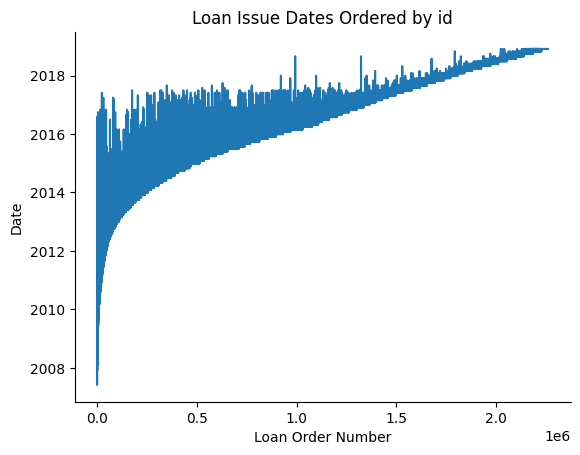

In [8]:
df_acc_clean = (
    df_acc.pipe(functions.drop_duplicates_ignore_first_col)
    .pipe(functions.remove_text_cast_col, col="id")
    .pipe(functions.parse_to_datetime, col="issue_d", fmt="%b-%Y")
)
plt.plot(
    df_acc_clean.sort("id").select("issue_d_parsed").collect().to_numpy().flatten()
)
sns.despine()
plt.title("Loan Issue Dates Ordered by id")
plt.ylabel("Date")
plt.xlabel("Loan Order Number")
plt.show()

Seems that when we order the observations by id, we get some inconsistent dates.

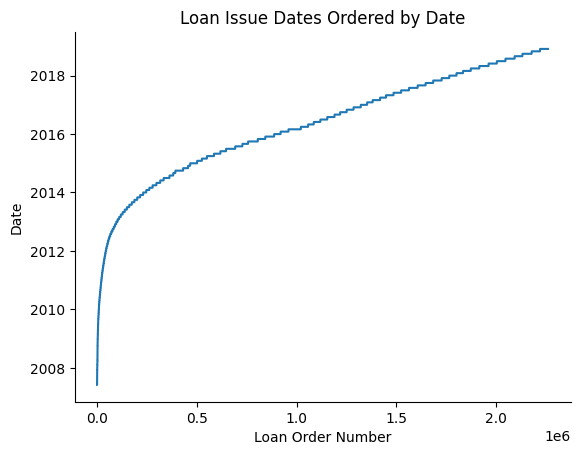

In [9]:
df_acc_clean = df_acc_clean.sort(["issue_d_parsed", "id"])

plt.plot(df_acc_clean.select("issue_d_parsed").collect().to_numpy().flatten())
sns.despine()
plt.title("Loan Issue Dates Ordered by Date")
plt.ylabel("Date")
plt.xlabel("Loan Order Number")
plt.show()

Since ordering by date itself smoothens out the data, we'll keep this approach.



Assumption: there may or may not be a different loan acceptance criteria based on the date. When splitting we will split very little data for testing from the very end and also another as sample from the whole range.

In [10]:
df_train_whole, df_test_tail, split_date_train = functions.fraction_split_by_date(
    df_acc_clean, "issue_d", "issue_d_parsed", train_fraction=0.95
)

The data starts with Jun-2007, ends with Dec-2018
Splitting test/train at Oct-2018, achieving 0.964 train data fraction.


In [11]:
df_train, df_test_sampled = functions.lazy_train_test_split(
    df_train_whole, train_fraction=0.95
)

parquet_file = os.path.join(data_folder, "acc_train.parquet")
df_train.collect().write_parquet(
    parquet_file, compression="snappy", row_group_size=100_000
)
parquet_file = os.path.join(data_folder, "acc_test_tail.parquet")
df_test_tail.collect().write_parquet(
    parquet_file, compression="snappy", row_group_size=100_000
)
parquet_file = os.path.join(data_folder, "acc_test_sampled.parquet")
df_test_sampled.collect().write_parquet(
    parquet_file, compression="snappy", row_group_size=100_000
)

### Splitting Rejected Loans

Load in rejected loans data.

In [12]:
path = os.path.join(
    data_folder, "rejected_2007_to_2018q4.csv", "rejected_2007_to_2018Q4.csv"
)
df_rej = pl.scan_csv(path)

Check for duplicates.

In [13]:
df_rej.collect().is_duplicated().value_counts()

,counts
bool,u32
false,27349253
true,299488


Drop the duplicates.

In [14]:
df_rej = df_rej.unique()
df_rej.collect().is_duplicated().value_counts()

,counts
bool,u32
false,27490787


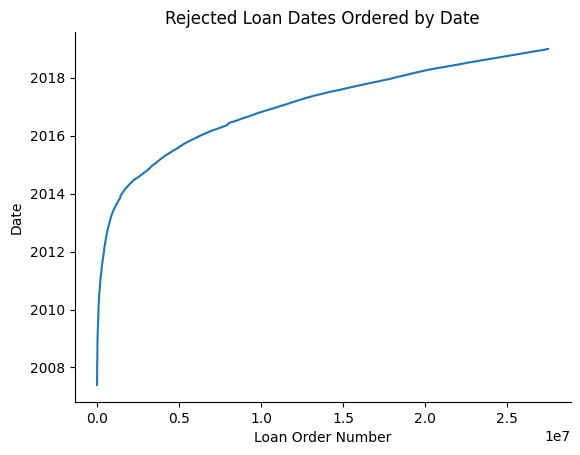

In [15]:
df_rej = df_rej.select(
    pl.all(),
    pl.col("Application Date")
    .str.to_datetime("%Y-%m-%d")
    .alias("Application Date Parsed"),
).sort("Application Date Parsed")
plt.plot(df_rej.select("Application Date Parsed").collect().to_numpy().flatten())
sns.despine()
plt.title("Rejected Loan Dates Ordered by Date")
plt.ylabel("Date")
plt.xlabel("Loan Order Number")
plt.show()

For splitting rejected loans we'll do same exact thing as we did with the accepted loans dataset. The only difference is that we already have the date to split on. We will only have to find the last day of month since accepted loans don't have the day of month recorded, but rejected loans do.

In [16]:
pd_date = pd.to_datetime(split_date_train)
last_day_of_month = pd_date + pd.offsets.MonthEnd(0)
last_day_of_month_np = np.datetime64(last_day_of_month)

df_train_whole, df_test_tail = functions.train_test_split_by_date(
    df_rej, "Application Date Parsed", last_day_of_month_np
)
df_train_whole = df_train_whole.drop("Application Date Parsed")
df_test_tail = df_test_tail.drop("Application Date Parsed")

df_train, df_test_sampled = functions.lazy_train_test_split(
    df_train_whole, train_fraction=0.95
)

parquet_file = os.path.join(data_folder, "rej_train.parquet")
df_train.collect().write_parquet(
    parquet_file, compression="snappy", row_group_size=100_000
)
parquet_file = os.path.join(data_folder, "rej_test_tail.parquet")
df_test_tail.collect().write_parquet(
    parquet_file, compression="snappy", row_group_size=100_000
)
parquet_file = os.path.join(data_folder, "rej_test_sampled.parquet")
df_test_sampled.collect().write_parquet(
    parquet_file, compression="snappy", row_group_size=100_000
)

## This Notebook's Output

The data has been split. Please navigate to step 2 notebook to continue reading.